In [9]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist, mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
# Imbalanced MNIST
def preprocess(dataset, imbalance_factor=0.01):

    ((X_train, Y_train), (X_test, Y_test)) = dataset.load_data()
    X_train_reshaped = X_train.reshape(len(X_train), -1)   
    X_test_reshaped = X_test.reshape(len(X_test), -1)

    X_train_norm = X_train_reshaped / 255            
    X_test_norm = X_test_reshaped / 255

    n_features = X_train_norm.shape[1]
    n_classes = 10

    print('Number of input features (image pixels) : ', n_features)
    print('Number of target classes (fashion categories) : ', n_classes)

    Y_train_onehot = to_categorical(Y_train, num_classes=n_classes)
    Y_test_onehot = to_categorical(Y_test, num_classes=n_classes)

    class_1_indices = np.where(Y_train == 1)[0]
    class_2_indices = np.where(Y_train == 2)[0]
    class_3_indices = np.where(Y_train == 3)[0]
    
    class_1_sampled = np.random.choice(class_1_indices, int(len(class_1_indices) * imbalance_factor), replace=False)
    class_2_sampled = np.random.choice(class_2_indices, int(len(class_2_indices) * imbalance_factor), replace=False)
    class_3_sampled = np.random.choice(class_3_indices, int(len(class_3_indices) * imbalance_factor), replace=False)

    other_classes_indices = np.where((Y_train != 1) & (Y_train != 2) & (Y_train != 3))[0]
    selected_indices = np.concatenate([class_1_sampled, class_2_sampled,class_3_sampled, other_classes_indices])

    X_train_imbalance = X_train_norm[selected_indices]
    Y_train_imbalance = Y_train_onehot[selected_indices]

    X_train_final, X_valid, Y_train_final, Y_valid = train_test_split(
        X_train_imbalance, Y_train_imbalance, test_size=0.16666, stratify=Y_train_imbalance
    )

    return (n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm, X_train_norm)


In [ ]:
# def preprocess(dataset):
#     ((X_train, Y_train), (X_test, Y_test)) = dataset.load_data()
#     X_train_reshaped = X_train.reshape(len(X_train), -1)   
#     X_test_reshaped = X_test.reshape(len(X_test), -1)

#     X_train_norm = X_train_reshaped/255            
#     X_test_norm = X_test_reshaped/255

#     n_features = X_train_norm.shape[1]
#     n_classes =  10

#     print('Number of input features (image pixels) : ', n_features)
#     print('Number of target classes (fashion categories) : ', n_classes)

#     Y_train_onehot = to_categorical(Y_train, num_classes = n_classes)
#     Y_test_onehot = to_categorical(Y_test, num_classes = n_classes)
#     X_train_final, X_valid, Y_train_final, Y_valid = train_test_split(X_train_norm, Y_train_onehot, 
#                                                                   test_size=0.16666)

#     return (n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid,X_test_norm)


def train(n_features, n_classes, model_name):
    model = Sequential()
    model.add(Dense(1000, input_dim = n_features, activation='relu', use_bias=False))

    model.add(Dense(200, activation='relu', use_bias=False))
    model.add(Dense(n_classes, activation='softmax', use_bias=False))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
    model.summary()
    save_at = str(model_name)
    save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, 
                             save_best_only=True, save_weights_only=False, mode='max')
    return (model,save_best)


def train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best):
    history = model.fit( X_train_final, Y_train_final, 
                        epochs = 1, batch_size = 20, 
                        callbacks=[save_best], verbose=1, 
                        validation_data = (X_valid, Y_valid) )

    plt.figure(figsize=(6, 5))
    plt.plot(history.history['accuracy'], color='r')
    plt.plot(history.history['val_accuracy'], color='b')
    plt.title('Model Accuracy', weight='bold', fontsize=16)
    plt.ylabel('accuracy', weight='bold', fontsize=14)
    plt.xlabel('epoch', weight='bold', fontsize=14)
    plt.ylim(0.5, 1)
    plt.xticks(weight='bold', fontsize=12)
    plt.yticks(weight='bold', fontsize=12)
    plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
    plt.grid(color = 'y', linewidth='0.5')
    plt.show()


def test(model, X_test_norm, Y_test_onehot):
    score = model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
    print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')
    Y_pred = np.round(model.predict(X_test_norm))

We will use five dense layers. We will set 'bias' to false for now, since that will make the weight matrices easier to work with. The weights of the final dense layers (the one leading to the output nodes) will not be pruned. But first, let's create the model and train it.

In [12]:
# pruning%
K = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

def weigh_pruning(X_test_norm, Y_test_onehot, K, trained_model, model_load):

    total_no_layers = len(trained_model.layers)

    all_weights = {}

    for layer_no in range(total_no_layers - 1):
        layer_weights = (pd.DataFrame(trained_model.layers[layer_no].get_weights()[0]).stack()).to_dict() 
        layer_weights = { (layer_no, k[0], k[1]): v for k, v in layer_weights.items() }
        all_weights.update(layer_weights)
    
    all_weights_sorted = {k: v for k, v in sorted(all_weights.items(), key=lambda item: abs(item[1]))}
    total_no_weights = len(all_weights_sorted) 
    # print(total_no_weights)
    print('all_weights',len(all_weights))
    weight_pruning_scores = []

    for pruning_percent in K:

        new_model = load_model(model_load)
        new_weights = trained_model.get_weights().copy()

        prune_fraction = pruning_percent/100
        number_of_weights_to_be_pruned = int(prune_fraction*total_no_weights)
        weights_to_be_pruned = {k: all_weights_sorted[k] for k in list(all_weights_sorted)[ :  number_of_weights_to_be_pruned]}     

        for k, v in weights_to_be_pruned.items():
            new_weights[k[0]][k[1], k[2]] = 0

        for layer_no in range(total_no_layers - 1) :
            new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
            new_model.layers[layer_no].set_weights(new_layer_weights)
        
        new_score  = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
        weight_pruning_scores .append(new_score[1])
    return weight_pruning_scores


def neuron_pruning(X_test_norm, Y_test_onehot, total_no_layers, trained_model, model_load):

    all_neurons = {}

    for layer_no in range(total_no_layers - 1):         

        layer_neurons = {}
        layer_neurons_df = pd.DataFrame(trained_model.layers[layer_no].get_weights()[0])

        for i in range(len(layer_neurons_df.columns)):
            layer_neurons.update({ i : np.array( layer_neurons_df.iloc[:,i] ) })    
                                                                    
        layer_neurons = { (layer_no, k): v for k, v in layer_neurons.items() }
        all_neurons.update(layer_neurons)
    
    all_neurons_sorted = {k: v for k, v in sorted(all_neurons.items(), key=lambda item: np.linalg.norm(item[1], ord=2, axis=0))}
    total_no_neurons = len(all_neurons_sorted) 
    # print(total_no_neurons)

    neuron_pruning_scores = []

    for pruning_percent in K:

        new_model = load_model(model_load)
        new_weights = trained_model.get_weights().copy()

        prune_fraction = pruning_percent/100
        number_of_neurons_to_be_pruned = int(prune_fraction*total_no_neurons)
        neurons_to_be_pruned = {k: all_neurons_sorted[k] for k in list(all_neurons_sorted)[ : number_of_neurons_to_be_pruned]}     

        for k, v in neurons_to_be_pruned.items():
            new_weights[k[0]][:, k[1]] = 0

        for layer_no in range(total_no_layers - 1) :
            new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
            new_model.layers[layer_no].set_weights(new_layer_weights)
        
        new_score  = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
        neuron_pruning_scores.append(new_score[1])
    return neuron_pruning_scores

In [13]:
import numpy as np
from keras.models import Model

# nc  + std
def compute_gradient_Sw(X_train_norm, Y_train_onehot, trained_model):
    """
    Compute the gradient of the within-class scatter matrix (S_w) for each layer.
    """
    N = X_train_norm.shape[0] 
    output_dim = trained_model.layers[-1].output_shape[1]  
    
    gradient_Sw = {}
    all_weights = {}

    for layer_no, layer in enumerate(trained_model.layers[:-1]):

        layer_model = Model(inputs=trained_model.input, outputs=layer.output)
        H_layer = layer_model.predict(X_train_norm)
        print(f"Layer {layer_no} activation shape: {H_layer.shape}")

        mu_c = np.zeros((output_dim, H_layer.shape[1]))
        for c in range(output_dim):
            class_samples = H_layer[Y_train_onehot[:, c] == 1]
            mu_c[c] = np.mean(class_samples, axis=0)

        W = layer.get_weights()[0]  
        grad_Sw = np.zeros_like(W)

        for i in range(N):
            for c in range(output_dim):
                if Y_train_onehot[i, c] == 1:
                    diff = H_layer[i] - mu_c[c]


                    diff_projected = np.dot(diff, W.T) 

                    # x_i = X_test_norm[i]
                    # print(x_i)
                    
                    grad_Sw += 2 * np.outer(diff_projected, diff) 

        gradient_Sw[layer_no] = grad_Sw
        print('gradient_Sw',len(gradient_Sw))
    return gradient_Sw


def prune_weights_using_Sw(X_test_norm, Y_test_onehot, X_train_norm, Y_train_onehot, K, trained_model, model_load):
    """
    Perform weight pruning using the gradient of the within-class scatter matrix (S_w),
    and rank the weights based on Neural Collapse scores.
    """
    gradient_Sw = compute_gradient_Sw(X_train_norm, Y_train_onehot, trained_model)
    total_no_layers = len(trained_model.layers)
    weight_pruning_scores = []

    all_weights = {}
    all_ranking_scores = {}

    for layer_no in range(total_no_layers - 1):
        if layer_no not in gradient_Sw:
            print(f"Warning: No gradient found for layer {layer_no}. Skipping this layer.")
            continue

        grad_Sw = gradient_Sw[layer_no]
        print('grad_Sw',grad_Sw)
        print(f"Layer {layer_no}: Gradient shape: {grad_Sw.shape}")

        weight_importance = np.linalg.norm(grad_Sw, ord=2)
        
        W = trained_model.layers[layer_no].get_weights()[0] 
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                all_weights[(layer_no, i, j)] = W[i, j]
                all_ranking_scores[(layer_no, i, j)] = np.abs(grad_Sw[i, j])

    all_weights_sorted = {k: v for k, v in sorted(all_ranking_scores.items(), key=lambda item: item[1])}

    total_no_weights = len(all_weights_sorted)
    print(f"Total weights to consider: {total_no_weights}")

    for pruning_percent in K:
    
        new_model = load_model(model_load)
        new_weights = new_model.get_weights().copy()

        prune_fraction = pruning_percent / 100
        number_of_weights_to_be_pruned = int(prune_fraction * total_no_weights)
        weights_to_be_pruned = list(all_weights_sorted.keys())[:number_of_weights_to_be_pruned]

        for k in weights_to_be_pruned:
            layer_no, i, j = k
            new_weights[layer_no][i, j] = 0

        for layer_no in range(total_no_layers - 1):
            new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
            new_model.layers[layer_no].set_weights(new_layer_weights)

        new_score = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
        weight_pruning_scores.append((pruning_percent, new_score[1]))

    return weight_pruning_scores


In [22]:
import numpy as np
from keras.models import Model

def compute_gradient_Sw(X_test_norm, Y_test_onehot, trained_model):
    """
    Compute the gradient of the within-class scatter matrix (S_w) for each layer.
    """
    N = X_test_norm.shape[0] 
    output_dim = trained_model.layers[-1].output_shape[1]  
    
    gradient_Sw = {}

    for layer_no, layer in enumerate(trained_model.layers[:-1]):
        layer_model = Model(inputs=trained_model.input, outputs=layer.output)
        H_layer = layer_model.predict(X_test_norm)
        print(f"Layer {layer_no} activation shape: {H_layer.shape}")

        # Initialize mean for each class
        mu_c = np.zeros((output_dim, H_layer.shape[1]))
        for c in range(output_dim):
            class_samples = H_layer[Y_test_onehot[:, c] == 1]
            mu_c[c] = np.mean(class_samples, axis=0)

        W = layer.get_weights()[0]  # Get the weight matrix for the layer
        grad_Sw = np.zeros_like(W)

        # Compute the gradient of S_w for the current layer
        for i in range(N):
            for c in range(output_dim):
                if Y_test_onehot[i, c] == 1:
                    # Activation for the sample
                    h_i = H_layer[i]
                    # Compute the gradient term (h_i - mu_c) * x_i^T
                    diff = h_i - mu_c[c]
                    x_i = X_test_norm[i]
                    print('xi',x_i.shape)
                    print('diff',diff.shape)
                    grad_Sw += 2 * np.outer(diff, x_i)

        gradient_Sw[layer_no] = grad_Sw
    return gradient_Sw


def prune_weights_using_Sw(X_test_norm, Y_test_onehot, K, trained_model, model_load):
    """
    Perform weight pruning using the gradient of the within-class scatter matrix (S_w),
    and rank the weights based on Neural Collapse scores.
    """
    gradient_Sw = compute_gradient_Sw(X_test_norm, Y_test_onehot, trained_model)
    total_no_layers = len(trained_model.layers)
    weight_pruning_scores = []

    all_weights = {}
    all_ranking_scores = {}

    for layer_no in range(total_no_layers - 1):
        if layer_no not in gradient_Sw:
            print(f"Warning: No gradient found for layer {layer_no}. Skipping this layer.")
            continue

        grad_Sw = gradient_Sw[layer_no]
        print(grad_Sw)
        print(f"Layer {layer_no}: Gradient shape: {grad_Sw.shape}")

        weight_importance = np.linalg.norm(grad_Sw, ord=2)
        
        W = trained_model.layers[layer_no].get_weights()[0]  
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                all_weights[(layer_no, i, j)] = W[i, j]
                all_ranking_scores[(layer_no, i, j)] = np.abs(grad_Sw[i, j])

    all_weights_sorted = {k: v for k, v in sorted(all_ranking_scores.items(), key=lambda item: item[1])}

    total_no_weights = len(all_weights_sorted)
    print(f"Total weights to consider: {total_no_weights}")

    for pruning_percent in K:
        new_model = load_model(model_load)
        new_weights = new_model.get_weights().copy()

        prune_fraction = pruning_percent / 100
        number_of_weights_to_be_pruned = int(prune_fraction * total_no_weights)

        weights_to_be_pruned = list(all_weights_sorted.keys())[:number_of_weights_to_be_pruned]

        for k in weights_to_be_pruned:
            layer_no, i, j = k
            new_weights[layer_no][i, j] = 0

        for layer_no in range(total_no_layers - 1):
            new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
            new_model.layers[layer_no].set_weights(new_layer_weights)

        new_score = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
        weight_pruning_scores.append((pruning_percent, new_score[1]))

    return weight_pruning_scores


In [14]:
def plots(standard_w, standard__neuron, nc, imbalance):
    plt.figure(figsize=(8, 4))
    plt.plot(pd.DataFrame(standard_w).set_index(pd.Series(K), drop=True), color='r')
    plt.plot(pd.DataFrame(standard__neuron).set_index(pd.Series(K), drop=True), color='g')
    plt.plot(pd.DataFrame(nc).set_index(pd.Series(K), drop=True), color='b')
    plt.title('Effect of Pruning on Accuracy (Imbalance = ' + imbalance + ')', fontsize=10)
    plt.ylabel('Score', fontsize=8)
    plt.xlabel('Pruning Percentage', fontsize=8)
    
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(['standard_w_pruning', 'standard_neuron_pruning', 'NC_pruning'], loc='best', prop={'size': 8})
    
    plt.grid(color='gray', linestyle='-', linewidth=0.3)
    filename = f"{imbalance}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


Number of input features (image pixels) :  784
Number of target classes (fashion categories) :  10


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1000)              784000    
                                                                 
 dense_7 (Dense)             (None, 200)               200000    
                                                                 
 dense_8 (Dense)             (None, 10)                2000      
                                                                 
Total params: 986000 (3.76 MB)
Trainable params: 986000 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1724/1724 [==============================] - 4s 2ms/step - loss: 0.2852 - accuracy: 0.9253 - val_loss: 0.1449 - val_accuracy: 0.9591


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


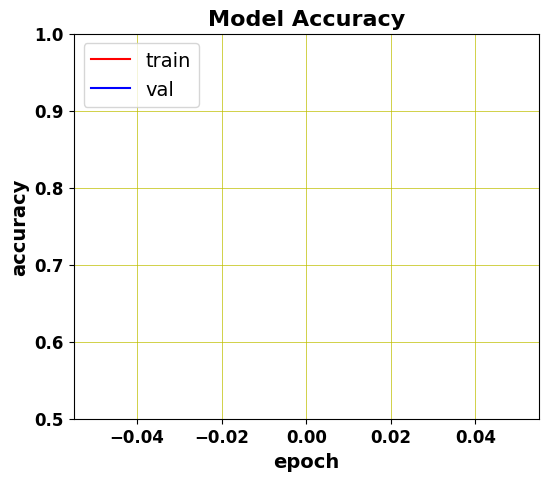

Accuracy over the test set: 
  72.05 %
313/313 [==============================] - 0s 713us/step
all_weights 984000
1875/1875 [==============================] - 1s 559us/step
Layer 0 activation shape: (60000, 1000)
gradient_Sw 1
1875/1875 [==============================] - 1s 720us/step
Layer 1 activation shape: (60000, 200)
gradient_Sw 2
grad_Sw [[  376.12286    601.1831     -68.11735  ...   718.0717    -311.70584
    608.73193 ]
 [   41.60181    399.64932   -449.54343  ...  -279.8156     863.32336
   -677.5971  ]
 [  -42.487026  1675.1553    2001.933    ...  1795.1892     -73.590706
    259.45505 ]
 ...
 [   66.24964  -1169.493     -811.94714  ... -1184.3291    1376.3728
   -500.9389  ]
 [  114.62484   -862.1623    -584.6246   ... -1687.7023     -53.39014
   -191.98553 ]
 [  363.33658   -230.82675    -36.207096 ...   398.92368    151.86311
   1288.6189  ]]
Layer 0: Gradient shape: (784, 1000)
grad_Sw [[ 4.5662970e+02  3.6596592e+03 -3.7856401e+03 ... -4.5325781e+03
  -4.2324258e+03  7

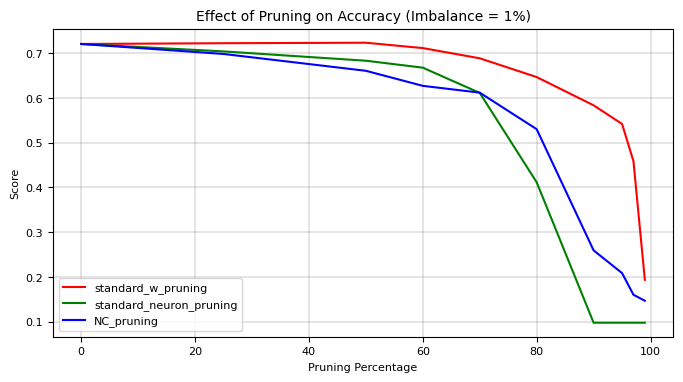

In [17]:
n_features, n_classes, Y_train_onehot, Y_test_onehot, X_train_final, X_valid, Y_train_final, Y_valid, X_test_norm,X_train_norm = preprocess(mnist,imbalance_factor=0.01)
model,save_best = train(n_features, n_classes, 'mnist.hdf5')
train_plots(model,X_train_final, Y_train_final, X_valid, Y_valid, save_best)
test(model, X_test_norm, Y_test_onehot)
trained_model = load_model("mnist.hdf5")
weight_pruning_scores = weigh_pruning(X_test_norm, Y_test_onehot, K, trained_model, 'mnist.hdf5')
total_no_layers = len(trained_model.layers)
neuron_pruning_scores = neuron_pruning(X_test_norm, Y_test_onehot, total_no_layers, trained_model, 'mnist.hdf5')
weight_pruning_scores_nc = prune_weights_using_Sw(X_test_norm, Y_test_onehot,X_train_norm, Y_train_onehot, K, trained_model, 'mnist.hdf5')
plots(weight_pruning_scores,neuron_pruning_scores, list(map(lambda x: x[1], weight_pruning_scores_nc)),'1%')

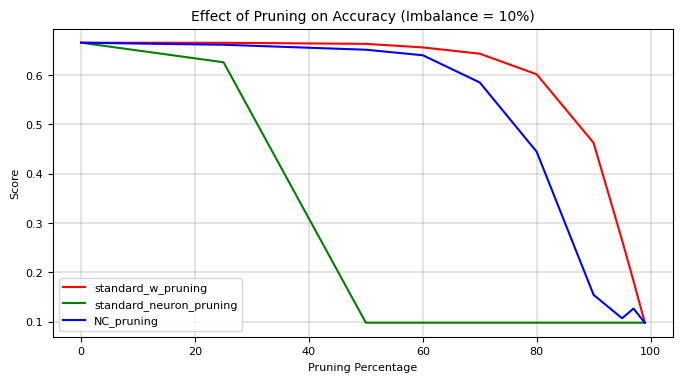